In [1]:
# Base import and functions

import imutils
import cv2
from imutils import contours
import os, os.path

from tqdm import tqdm

import pytesseract             # Python interface to tesseract for OCR

import numpy as np
from PIL import Image

from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist, adjust_log
from skimage.restoration import denoise_tv_chambolle, denoise_wavelet, denoise_bilateral
from skimage.filters import threshold_niblack
from skimage.util import img_as_float, img_as_ubyte, img_as_uint
from skimage.morphology import reconstruction
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import disk, diamond, square
from skimage.filters import rank

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%load_ext line_profiler

import skimage
print("skimage: " + skimage.__version__)  # Must be greater then 0.14 for Chain Vesa

skimage: 0.14dev


In [29]:
def numberprepare(image):

    img = img_as_float(image)
    logarithmic_corrected = adjust_log(img, 1)
    img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
    gray = rgb2gray(img_log_clah)

    seed = np.copy(gray)
    seed[1:-1, 1:-1] = gray.max()
    mask = gray

    filled = reconstruction(seed, mask, method='erosion')
    holes = denoise_wavelet(rank.enhance_contrast(gray-filled+1, disk(6)))
    # niblack = holes > threshold_niblack(holes, window_size=71, k=0.9)

    return holes
    return remove_small_holes(img_as_ubyte(niblack), 300)

def serialprepare(image):

    img = img_as_float(image)
    logarithmic_corrected = adjust_log(img, 1)
    img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
    gray = rgb2gray(img_log_clah)

    holes = denoise_tv_chambolle(rank.enhance_contrast(gray, disk(8)), weight=0.3)
    # niblack = holes > threshold_niblack(holes, window_size=61, k=0.9)

    return holes
    return remove_small_holes(img_as_ubyte(niblack), 400)

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


CPU times: user 35 ms, sys: 0 ns, total: 35 ms
Wall time: 34.9 ms
CPU times: user 62.1 ms, sys: 0 ns, total: 62.1 ms
Wall time: 62.1 ms


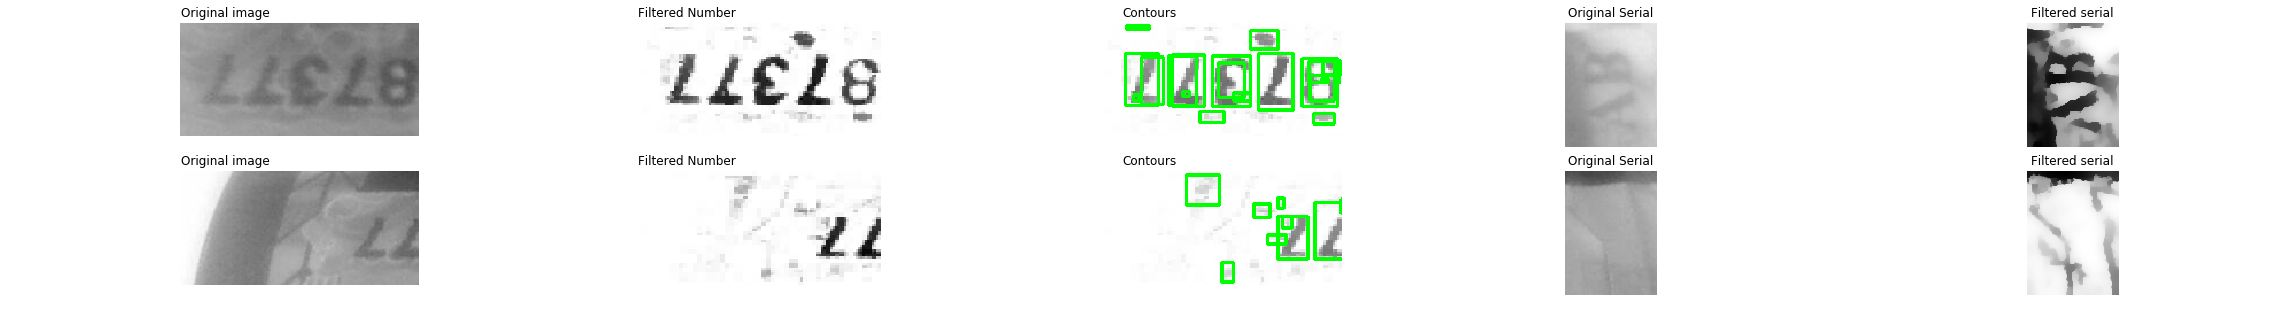

In [33]:
src = Image.open('test_data/final720/photo1.jpg')
src2 = Image.open('test_data/final720/photo2.jpg')

# First source
# rotated = src.rotate(-90, expand=True)

serial = src.crop((1043, 218, 1043+80, 218+108))
%time filtered_serial = serialprepare(serial)

number = src.crop((89, 218, 89+399, 218+99))
%time filtered_number = numberprepare(number)
thresholded = img_as_ubyte(filtered_number)

edged = cv2.Canny(thresholded, 30, 200)
width, height = thresholded.shape[:2]

refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
# refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
# refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
 
# create a clone of the original image so we can draw on it
clone = np.dstack([thresholded.copy()] * 3)
 
# loop over the (sorted) contours
for c in refCnts:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

# Secong source

serial2 = src2.crop((1043, 218, 1043+80, 218+108))
filtered_serial2 = serialprepare(serial2)

number2 = src2.crop((89, 218, 89+399, 218+99))
filtered_number2 = numberprepare(number2)
thresholded2 = img_as_ubyte(filtered_number2)

edged = cv2.Canny(thresholded2, 30, 200)
width, height = thresholded.shape[:2]

refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
# refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
# refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
 
# create a clone of the original image so we can draw on it
clone2 = np.dstack([thresholded2.copy()] * 3)
 
# loop over the (sorted) contours
for c in refCnts:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(clone2, (x, y), (x + w, y + h), (0, 255, 0), 2)

fig, ax = plt.subplots(2, 5, figsize=(40, 5), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(number)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(filtered_number, cmap='gray')
ax[1].set_title('Filtered Number')
ax[1].axis('off')

ax[2].imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
ax[2].set_title('Contours')
ax[2].axis('off')

ax[3].imshow(serial, cmap='gray')
ax[3].set_title('Original Serial')
ax[3].axis('off')

ax[4].imshow(filtered_serial, cmap='gray')
ax[4].set_title('Filtered serial')
ax[4].axis('off')

ax[5].imshow(number2)
ax[5].set_title('Original image')
ax[5].axis('off')

ax[6].imshow(filtered_number2, cmap='gray')
ax[6].set_title('Filtered Number')
ax[6].axis('off')

ax[7].imshow(cv2.cvtColor(clone2, cv2.COLOR_BGR2RGB))
ax[7].set_title('Contours')
ax[7].axis('off')

ax[8].imshow(serial2, cmap='gray')
ax[8].set_title('Original Serial')
ax[8].axis('off')

ax[9].imshow(filtered_serial2, cmap='gray')
ax[9].set_title('Filtered serial')
ax[9].axis('off')

plt.show()

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boole

CPU times: user 55.6 ms, sys: 7.95 ms, total: 63.5 ms
Wall time: 63.4 ms
CPU times: user 1.68 ms, sys: 7.73 ms, total: 9.4 ms
Wall time: 145 ms
953587377


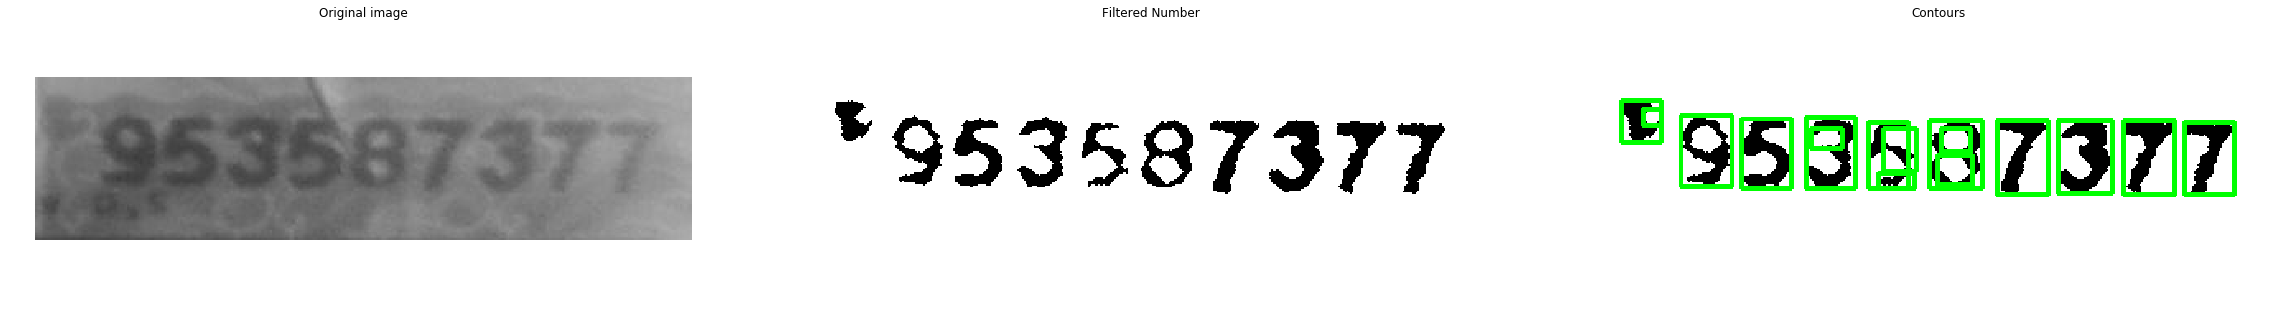

In [62]:
from skimage.filters import threshold_mean
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.morphology import erosion, dilation, opening, closing, binary_opening, binary_closing

def numberprepare(image):

    img = img_as_float(image)
    logarithmic_corrected = adjust_log(img, 1)
    img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
    gray = rgb2gray(img_log_clah)

    seed = np.copy(gray)
    seed[1:-1, 1:-1] = gray.max()
    mask = gray

    filled = reconstruction(seed, mask, method='erosion')
    # holes = denoise_wavelet(rank.enhance_contrast(gray-filled+1, disk(6)))
    # niblack = holes > threshold_niblack(holes, window_size=71, k=0.9)
    holes = rank.enhance_contrast(gray-filled+1, disk(6))
    
    thresh_min = threshold_mean(holes)
    binary_min = holes > thresh_min
    
    filtered_smallest_noise = remove_small_holes(img_as_ubyte(binary_min), 10)
    
    opened = binary_opening(filtered_smallest_noise, disk(2))
    
    filtered_larger_noise = remove_small_holes(img_as_ubyte(opened), 300)

    return filtered_larger_noise

src = Image.open('test_data/final720/photo1.jpg')

# First source
# rotated = src.rotate(-90, expand=True)

serial = src.crop((1043, 218, 1043+80, 218+108))
filtered_serial = serialprepare(serial)

number = src.crop((89, 218, 89+399, 218+99)).rotate(180, expand=True)
%time filtered_number = numberprepare(number)
%time numberCandidate = pytesseract.image_to_string(Image.fromarray(filtered_number, "L"), config="--tessdata-dir ./tessdata -psm 8 -oem 3 -l eng -c tessedit_char_whitelist=1234567890 nobatch digits")
thresholded = img_as_ubyte(filtered_number)

edged = cv2.Canny(thresholded, 30, 200)
width, height = thresholded.shape[:2]

refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
# refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
# refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
 
# create a clone of the original image so we can draw on it
clone = np.dstack([thresholded.copy()] * 3)
 
# loop over the (sorted) contours
for c in refCnts:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

fig, ax = plt.subplots(1, 3, figsize=(40, 5), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(number)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(filtered_number, cmap='gray')
ax[1].set_title('Filtered Number')
ax[1].axis('off')

ax[2].imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
ax[2].set_title('Contours')
ax[2].axis('off')

print(numberCandidate)

### Recognition is fine when we cut all trash blobs. But it is a little bit risky

We must use `remove_small_holes(img_as_ubyte(opened), 50)` or something like.

But not like this `remove_small_holes(img_as_ubyte(opened), 300)`

/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/util/dtype.py:123: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/media/levabd/ScienceProjects/Code/Science-Repos/scikit-image/skimage/morphology/misc.py:203: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boole

CPU times: user 60.2 ms, sys: 4.03 ms, total: 64.3 ms
Wall time: 64.1 ms
CPU times: user 5.75 ms, sys: 3.73 ms, total: 9.48 ms
Wall time: 177 ms
7335537377


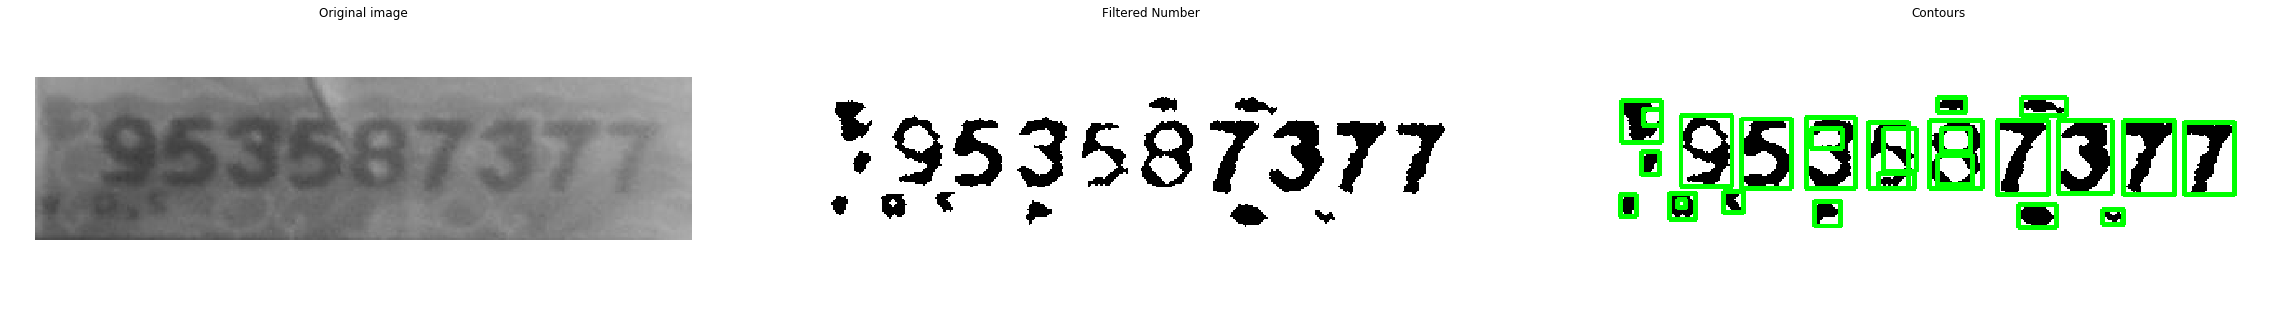

In [63]:
def numberprepare(image):

    img = img_as_float(image)
    logarithmic_corrected = adjust_log(img, 1)
    img_log_clah = equalize_adapthist(logarithmic_corrected, clip_limit=0.03)
    gray = rgb2gray(img_log_clah)

    seed = np.copy(gray)
    seed[1:-1, 1:-1] = gray.max()
    mask = gray

    filled = reconstruction(seed, mask, method='erosion')
    # holes = denoise_wavelet(rank.enhance_contrast(gray-filled+1, disk(6)))
    # niblack = holes > threshold_niblack(holes, window_size=71, k=0.9)
    holes = rank.enhance_contrast(gray-filled+1, disk(6))
    
    thresh_min = threshold_mean(holes)
    binary_min = holes > thresh_min
    
    filtered_smallest_noise = remove_small_holes(img_as_ubyte(binary_min), 10)
    
    opened = binary_opening(filtered_smallest_noise, disk(2))
    
    filtered_larger_noise = remove_small_holes(img_as_ubyte(opened), 50)

    return filtered_larger_noise

src = Image.open('test_data/final720/photo1.jpg')

# First source
# rotated = src.rotate(-90, expand=True)

serial = src.crop((1043, 218, 1043+80, 218+108))
filtered_serial = serialprepare(serial)

number = src.crop((89, 218, 89+399, 218+99)).rotate(180, expand=True)
%time filtered_number = numberprepare(number)
%time numberCandidate = pytesseract.image_to_string(Image.fromarray(filtered_number, "L"), config="--tessdata-dir ./tessdata -psm 8 -oem 3 -l eng -c tessedit_char_whitelist=1234567890 nobatch digits")
thresholded = img_as_ubyte(filtered_number)

edged = cv2.Canny(thresholded, 30, 200)
width, height = thresholded.shape[:2]

refCnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[1]
# refCnts = refCnts[0] if imutils.is_cv2() else refCnts[1]
# refCnts = contours.sort_contours(refCnts, method="left-to-right")[0]
 
# create a clone of the original image so we can draw on it
clone = np.dstack([thresholded.copy()] * 3)
 
# loop over the (sorted) contours
for c in refCnts:
    # compute the bounding box of the contour and draw it on our
    # image
    (x, y, w, h) = cv2.boundingRect(c)
    cv2.rectangle(clone, (x, y), (x + w, y + h), (0, 255, 0), 2)

fig, ax = plt.subplots(1, 3, figsize=(40, 5), sharex=True, sharey=True)
ax = ax.ravel()

ax[0].imshow(number)
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(filtered_number, cmap='gray')
ax[1].set_title('Filtered Number')
ax[1].axis('off')

ax[2].imshow(cv2.cvtColor(clone, cv2.COLOR_BGR2RGB))
ax[2].set_title('Contours')
ax[2].axis('off')

print(numberCandidate)

With removing 50 blobs tesseract fails